# Введение

Нас (возможно и вас) пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats
import itertools as it

# Ознакомление
Для начала загрузим файл в датафрейм (ДФ), переименуем некоторые колонки для удобства и посмотрим развернутый ДФ.

In [2]:
df = pd.read_csv('stud_math.csv')
df.rename(columns={'studytime, granular': 'studytime_granular',
                         'Pstatus': 'pstatus', 'Medu': 'medu', 'Fedu': 'fedu',
                         'Mjob': 'mjob', 'Fjob': 'fjob'}, inplace=True)
pd.set_option('max_columns', None)

In [3]:
df.sample(10)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
123,GP,M,16,U,GT3,T,4.0,4.0,health,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,4.0,4.0,5.0,18.0,65.0
122,GP,F,16,U,LE3,T,2.0,4.0,other,health,course,father,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,yes,4.0,2.0,2.0,5.0,2.0,65.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,reputation,father,2.0,2.0,0.0,no,yes,no,NaN,yes,-6.0,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
298,GP,F,18,U,GT3,NaN,4.0,3.0,other,other,reputation,father,1.0,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,3.0,3.0,0.0,70.0
167,GP,F,16,U,NaN,T,4.0,2.0,health,services,home,father,1.0,2.0,0.0,no,NaN,yes,no,yes,-6.0,yes,yes,yes,4.0,2.0,3.0,3.0,0.0,80.0
113,GP,M,15,U,LE3,T,4.0,2.0,teacher,other,course,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,yes,no,3.0,5.0,2.0,3.0,10.0,95.0
378,MS,F,18,U,GT3,T,3.0,3.0,other,other,home,mother,1.0,2.0,0.0,no,no,yes,no,yes,-6.0,yes,yes,yes,4.0,1.0,3.0,1.0,0.0,75.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0
269,GP,F,18,R,GT3,T,2.0,1.0,other,other,reputation,mother,2.0,2.0,0.0,no,NaN,no,no,yes,-6.0,no,yes,yes,4.0,3.0,5.0,3.0,0.0,0.0


#### Значения колонок датафрейма

school — аббревиатура школы, в которой учится ученик

sex — пол ученика ('F' - женский, 'M' - мужской)

age — возраст ученика (от 15 до 22)

address — тип адреса ученика ('U' - городской, 'R' - за городом)

famsize — размер семьи('LE3' <= 3, 'GT3' >3)

Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

schoolsup — дополнительная образовательная поддержка (yes или no)

famsup — семейная образовательная поддержка (yes или no)

paid — дополнительные платные занятия по математике (yes или no)

activities — дополнительные внеучебные занятия (yes или no)

nursery — посещал детский сад (yes или no)

higher — хочет получить высшее образование (yes или no)

internet — наличие интернета дома (yes или no)

romantic — в романтических отношениях (yes или no)

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

absences — количество пропущенных занятий

score — баллы по госэкзамену по математике

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [5]:
# Посмотрим кол-во пропусков в колонках
df.isna().sum()

school                 0
sex                    0
age                    0
address               17
famsize               27
pstatus               45
medu                   3
fedu                  24
mjob                  19
fjob                  36
reason                17
guardian              31
traveltime            28
studytime              7
failures              22
schoolsup              9
famsup                39
paid                  40
activities            14
nursery               16
studytime_granular     7
higher                20
internet              34
romantic              31
famrel                27
freetime              11
goout                  8
health                15
absences              12
score                  6
dtype: int64

В датасете всего 30 колонок: 13 числовых колонок и 17 строковых. 
Датасете содержит данные данные о 395 учениках.
Во всех колонках, кроме school, sex, age есть пустые значения.

### Предобработка

In [6]:
# Функция для получения быстрой справки о данных в числовых колонках
def info_dig(x):
    print(pd.DataFrame(x.value_counts()))
    print('Пропущенных значений -', x.isnull().values.sum())
    x.hist()

In [7]:
# Функция для получения быстрой справки о данных в текстовых колонках
def info_object(smth):
    print(pd.DataFrame(smth.value_counts()))
    print('Пропущенных значений -', smth.isnull().values.sum())
    sns.boxplot(x=smth, y='score', data=df)

### Просмотр числовыx столбцов

    age
16  104
17   98
18   82
15   82
19   24
20    3
22    1
21    1
Пропущенных значений - 0


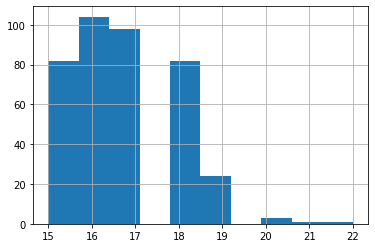

In [8]:
info_dig(df.age)

     medu
4.0   131
2.0   102
3.0    97
1.0    59
0.0     3
Пропущенных значений - 3


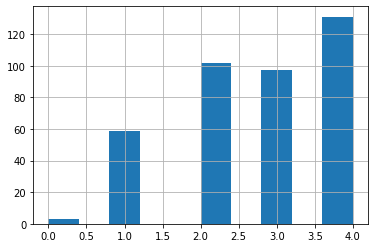

In [9]:
info_dig(df.medu)

In [10]:
# Заполним пропуски средним значением
df.medu.fillna(round(df.medu.mean()), inplace=True)

      fedu
2.0    106
3.0     96
4.0     88
1.0     78
0.0      2
40.0     1
Пропущенных значений - 24


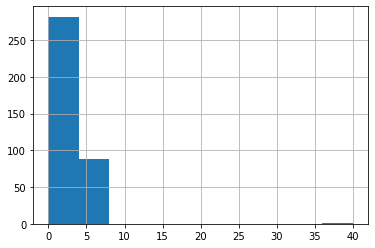

In [11]:
info_dig(df.fedu)

In [12]:
# Исправим опечатку значения 40.0, вероятно имелось ввиду 4.
df.fedu = df.fedu.apply(lambda x: x/10 if x > 9 else x)

In [13]:
# Заполним пропуски средним значением
df.fedu.fillna(round(df.fedu.mean()), inplace=True)

     traveltime
1.0         242
2.0          96
3.0          22
4.0           7
Пропущенных значений - 28


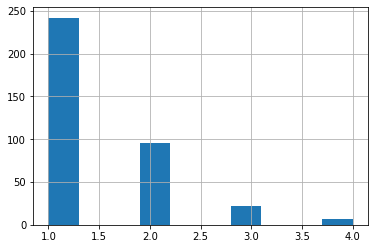

In [14]:
info_dig(df.traveltime)

In [15]:
# Заполним пропуски средним значением
df.traveltime.fillna(round(df.traveltime.mean()), inplace=True)

     studytime
2.0        194
1.0        103
3.0         64
4.0         27
Пропущенных значений - 7


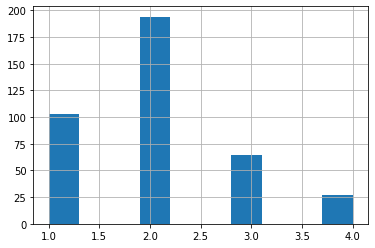

In [16]:
info_dig(df.studytime)

In [17]:
# Заполним пропуски средним значением
df.studytime.fillna(round(df.studytime.mean()), inplace=True)

     failures
0.0       293
1.0        49
2.0        16
3.0        15
Пропущенных значений - 22


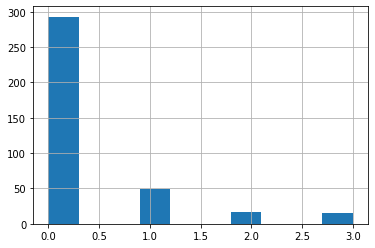

In [18]:
info_dig(df.failures)

In [19]:
# Заполним пропуски средним значением
df.failures.fillna(round(df.failures.mean()), inplace=True)

       studytime_granular
-6.0                  194
-3.0                  103
-9.0                   64
-12.0                  27
Пропущенных значений - 7


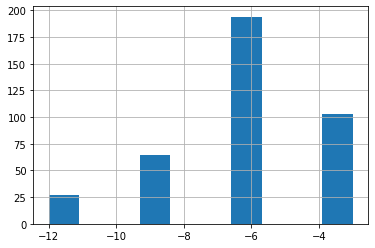

In [20]:
info_dig(df.studytime_granular)

In [21]:
# Заполним пропуски средним значением
df.studytime_granular.fillna(round(df.studytime_granular.mean()), inplace=True)

      famrel
 4.0     182
 5.0      99
 3.0      62
 2.0      17
 1.0       7
-1.0       1
Пропущенных значений - 27


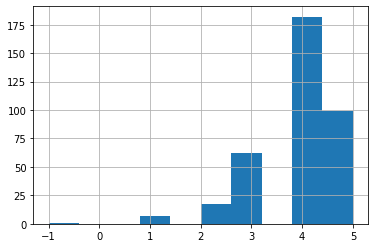

In [22]:
info_dig(df.famrel)

In [23]:
# Исправим опечатку значения -1.0, вероятно имелось ввиду 1.0
df.famrel = df.famrel.apply(lambda x: abs(x) if x < 0 else x)

In [24]:
# Заполним пропуски средним значением
df.famrel.fillna(round(df.famrel.mean()), inplace=True)

     freetime
3.0       153
4.0       112
2.0        63
5.0        38
1.0        18
Пропущенных значений - 11


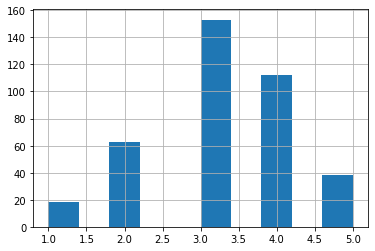

In [25]:
info_dig(df.freetime)

In [26]:
# Заполним пропуски средним значением
df.freetime.fillna(round(df.freetime.mean()), inplace=True)

     goout
3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Пропущенных значений - 8


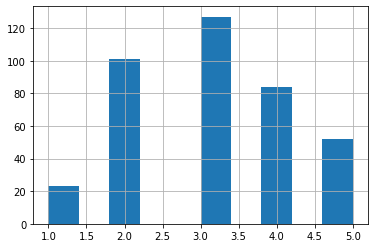

In [27]:
info_dig(df.goout)

In [28]:
# Заполним пропуски средним значением
df.goout.fillna(round(df.goout.mean()), inplace=True)

     health
5.0     138
3.0      89
4.0      63
1.0      47
2.0      43
Пропущенных значений - 15


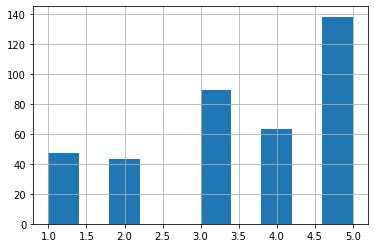

In [29]:
info_dig(df.health)

In [30]:
# Заполним пропуски средним значением
df.health.fillna(round(df.health.mean()), inplace=True)

       absences
0.0         111
2.0          60
4.0          53
6.0          31
8.0          21
10.0         17
12.0         12
14.0         12
3.0           8
16.0          7
7.0           6
5.0           5
18.0          5
20.0          4
22.0          3
9.0           3
1.0           3
15.0          2
13.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1
Пропущенных значений - 12


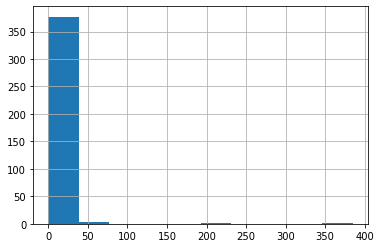

In [31]:
info_dig(df.absences)

In [32]:
# Вероятно, значения 212 и 385 являются ошибками, т.к. выходят за рамки кол-ва учебных дней и кол-ва дней в году соответственно.
# Удалим их из датасета.
df = df[~df.absences.isin([212.0,385.0])]

In [33]:
# Заполним пропуски медианным значением, т.к. достаточно большой разброс
df.absences.fillna(round(df.absences.median()), inplace=True)

      absences
0.0        111
4.0         65
2.0         60
6.0         31
8.0         21
10.0        17
14.0        12
12.0        12
3.0          8
16.0         7
7.0          6
5.0          5
18.0         5
20.0         4
1.0          3
22.0         3
9.0          3
15.0         2
13.0         2
11.0         2
54.0         1
25.0         1
17.0         1
26.0         1
56.0         1
23.0         1
28.0         1
21.0         1
75.0         1
30.0         1
19.0         1
38.0         1
40.0         1
24.0         1
Пропущенных значений - 0


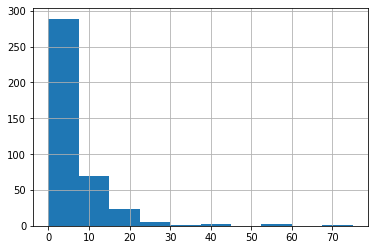

In [34]:
# Посмотрим еще раз не получившийся результат
info_dig(df.absences)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


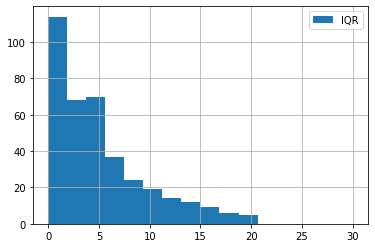

In [35]:
# Определим выбросы и удалим их
median = df.absences.median()
IQR = df.absences.quantile(0.75) - df.absences.quantile(0.25)
perc25 = df.absences.quantile(0.25)
perc75 = df.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), 
      '75-й перцентиль: {},'.format(perc75), 
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
df.absences.loc[df.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, 
                                                                              range = (0, 30), 
                                                                              label = 'IQR')
plt.legend();

In [36]:
# Выбросами считаем значения больше 30, 
# т.к. пропуск более 30 учебных дней скорее всего приведет к переводу ученика на домашнее обучение.
# Удалим выбросы

df = df[df.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

       score
50.0      54
55.0      42
0.0       37
75.0      33
60.0      31
65.0      30
40.0      28
70.0      27
45.0      23
80.0      16
30.0      14
90.0      10
35.0       9
25.0       7
95.0       5
85.0       5
100.0      1
Пропущенных значений - 6


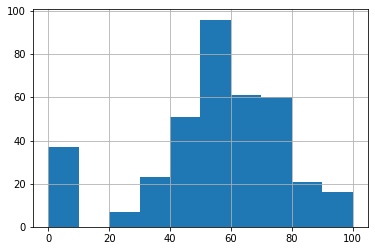

In [37]:
info_dig(df.score)

In [38]:
# Пропуски в целевой переменной можно удалить
df = df[~df.score.isna()]

### Просмотр строковых столбцов

    school
GP     328
MS      44
Пропущенных значений - 0


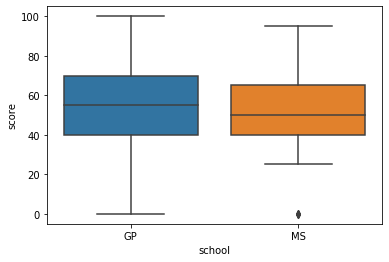

In [39]:
info_object(df.school)

   sex
F  191
M  181
Пропущенных значений - 0


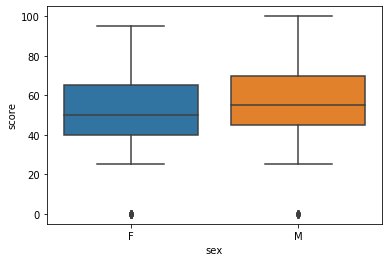

In [40]:
info_object(df.sex)

   address
U      276
R       81
Пропущенных значений - 15


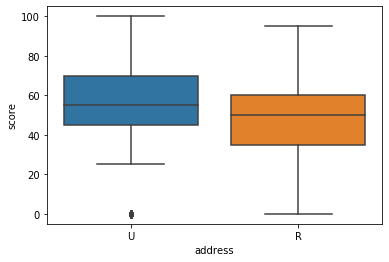

In [41]:
info_object(df.address)

In [42]:
# Чтобы заполнить пропуски найдем среднее время до школы для городских и загородных учеников
df.groupby(['address'])['traveltime'].mean().reset_index()

,address,traveltime
0,R,1.753086
1,U,1.300725


In [43]:
# Т.к. у нас круглые значения в traveltime - будем считать, что 2 и более - это загородные ученики. 
# Заполним пропуски следующим образом:

pd.set_option('mode.chained_assignment', None) # Чтобы не ругался

df = df.reset_index() # Сбросим индекс учеников, иначе алерт
df.address.fillna(0, inplace=True) # Заполним пропуски 0

for i in range(0, len(df)):
    if df.address[i] == 0:
        if df.traveltime[i] > 1.0:
            df.address[i] = 'R'
        else:
            df.address[i] = 'U'

     famsize
GT3      243
LE3      104
Пропущенных значений - 25


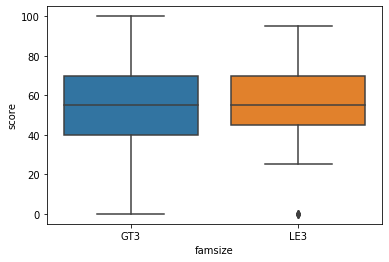

In [44]:
info_object(df.famsize)

In [45]:
# Заполним пропуски самым частовстречаемым значением
# Логическое предположение: родители живут вместе - больше семья
# Для этого обратимся к параметру Pstatus (Совместное проживание родителей)
df.groupby(['pstatus'])['famsize'].value_counts() 

pstatus  famsize
A        GT3         18
         LE3         12
T        GT3        200
         LE3         80
Name: famsize, dtype: int64

In [46]:
# Предположение не оправдалось, во всех группах преобладает значение GT3, им и заполним пропуски
df.famsize.fillna('GT3', inplace=True)

   pstatus
T      300
A       32
Пропущенных значений - 40


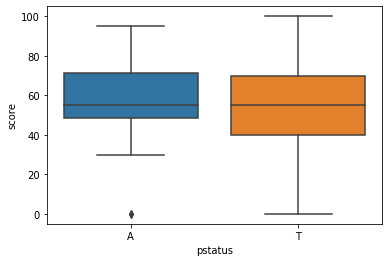

In [47]:
info_object(df.pstatus)

In [48]:
# Заполним пропуски самым частовстречаемым значением
df.pstatus.fillna('T', inplace=True)

          mjob
other      121
services    91
at_home     57
teacher     54
health      32
Пропущенных значений - 17


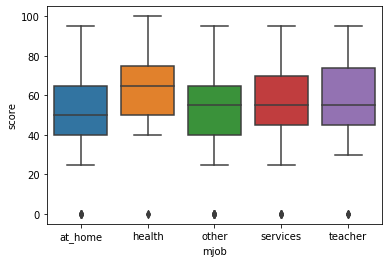

In [49]:
info_object(df.mjob)

In [50]:
# Заполним пропуски неопределенным значением
df.mjob.fillna('other', inplace=True)

          fjob
other      187
services    92
teacher     27
at_home     16
health      15
Пропущенных значений - 35


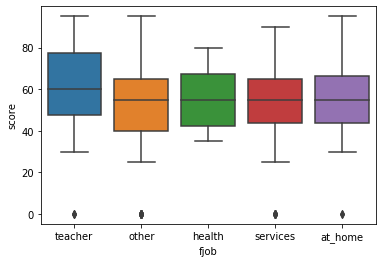

In [51]:
info_object(df.fjob)

In [52]:
# Заполним пропуски неопределенным значением
df.fjob.fillna('other', inplace=True)

            reason
course         133
reputation      97
home            92
other           33
Пропущенных значений - 17


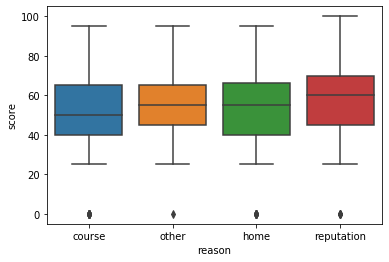

In [53]:
info_object(df.reason)

In [54]:
# Заполним пропуски самым частовстречаемым значением
df.reason.fillna('course', inplace=True)

        guardian
mother       236
father        85
other         21
Пропущенных значений - 30


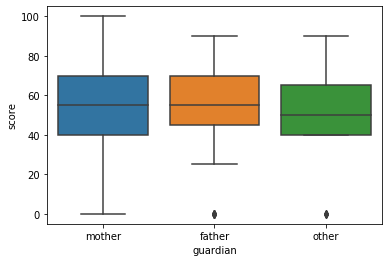

In [55]:
info_object(df.guardian)

In [56]:
# Заполним пропуски самым частовстречаемым значением
df.guardian.fillna('mother', inplace=True)

     schoolsup
no         317
yes         46
Пропущенных значений - 9


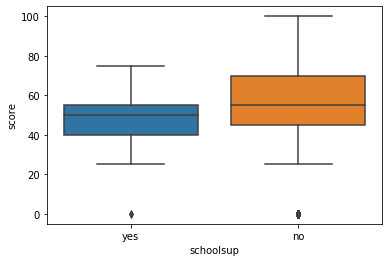

In [57]:
info_object(df.schoolsup)

In [58]:
# Заполним пропуски самым частовстречаемым значением
df.schoolsup.fillna('no', inplace=True)

     famsup
yes     207
no      131
Пропущенных значений - 34


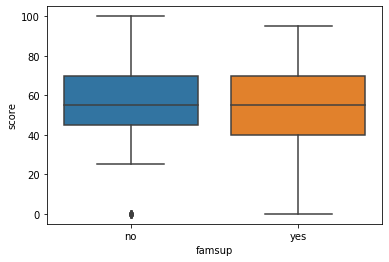

In [59]:
info_object(df.famsup)

In [60]:
# Заполним пропуски самым частовстречаемым значением
df.famsup.fillna('yes', inplace=True)

     paid
no    191
yes   143
Пропущенных значений - 38


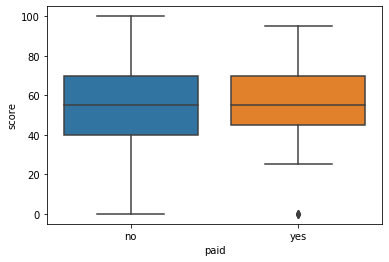

In [61]:
info_object(df.paid)

In [62]:
# Заполним пропуски самым частовстречаемым значением
df.paid.fillna('no', inplace=True)

     activities
yes         187
no          171
Пропущенных значений - 14


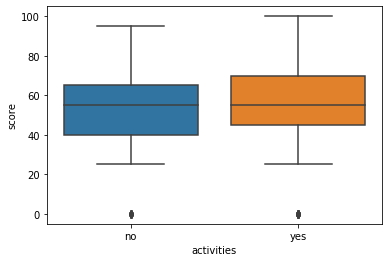

In [63]:
info_object(df.activities)

In [64]:
# Значения близкие, хочется распределить пропуски равномерно
# Заполним пропуски поочереди каждым значением

df.activities.fillna(0, inplace=True) # Заполним пропуски 0

for i in range(0, len(df)):
    counter = 0
    if df.activities[i] == 0:
        if counter % 2 == 0:
            df.activities[i] = 'yes'
            counter += 1
        else:
            df.activities[i] = 'no'
            counter += 1

     nursery
yes      283
no        74
Пропущенных значений - 15


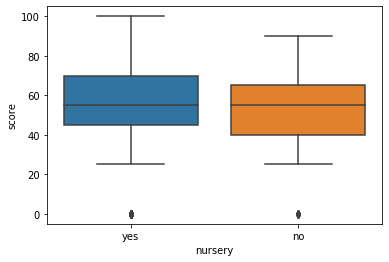

In [65]:
info_object(df.nursery)

In [66]:
# Заполним пропуски самым частовстречаемым значением
df.nursery.fillna('yes', inplace=True)

     higher
yes     335
no       18
Пропущенных значений - 19


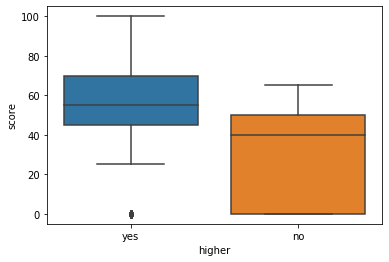

In [67]:
info_object(df.higher)

In [68]:
# Заполним пропуски самым частовстречаемым значением
df.higher.fillna('yes', inplace=True)

     internet
yes       285
no         54
Пропущенных значений - 33


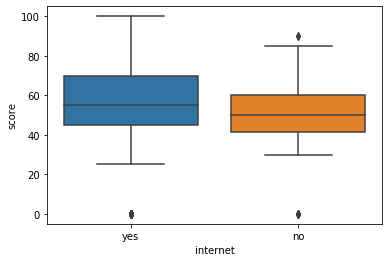

In [69]:
info_object(df.internet)

In [70]:
# Заполним пропуски самым частовстречаемым значением
df.internet.fillna('yes', inplace=True)

     romantic
no        229
yes       113
Пропущенных значений - 30


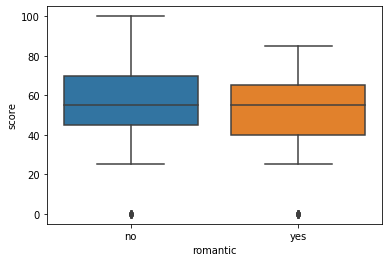

In [71]:
info_object(df.romantic)

In [72]:
# Заполним пропуски самым частовстречаемым значением
df.romantic.fillna('no', inplace=True)

In [73]:
# Финальная проверка на пропуски
df.isna().sum()

index                 0
school                0
sex                   0
age                   0
address               0
famsize               0
pstatus               0
medu                  0
fedu                  0
mjob                  0
fjob                  0
reason                0
guardian              0
traveltime            0
studytime             0
failures              0
schoolsup             0
famsup                0
paid                  0
activities            0
nursery               0
studytime_granular    0
higher                0
internet              0
romantic              0
famrel                0
freetime              0
goout                 0
health                0
absences              0
score                 0
dtype: int64

# Поиск зависимостей
Посмотрим корреляцию числовых значений

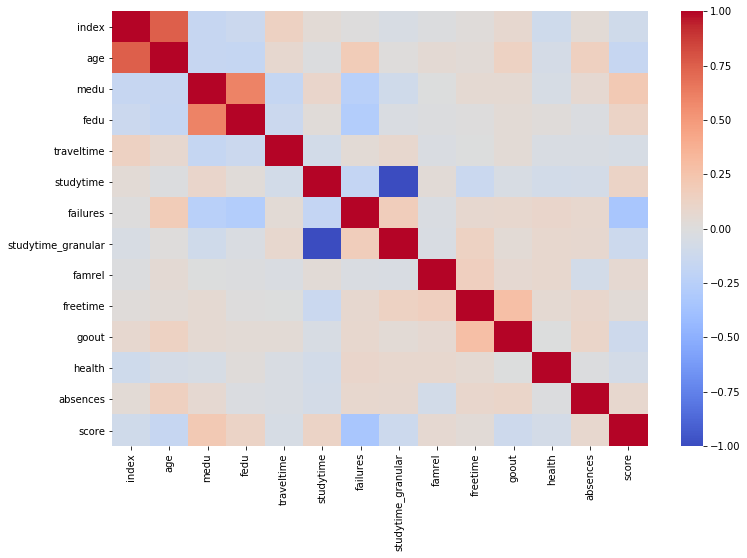

In [74]:
plt.rcParams['figure.figsize'] = (12,8)
sns.heatmap(df.corr(),cmap='coolwarm')

Полная корреляция столбцов studytime и studytime_granular позволяют не брать последний в рассчет.

Образование родителей (medu и fedu) и кол-во внеучебных неудач (failures) больше других оказывают влияние на успеваемость. Т.е. чем выше образование родителей, тем более успешный ребенок в жизни в целом, в том числе и в учебе. 

Также можно увидеть корреляцию возраста (age) и кол-ва внеучебных неудач (failures). Чем страше ребенок, тем хуже успеваемость. Можно предположить, что более молодые родители имеют лучшее образование, либо растущие дети начинают больше времени уделять друзьям (gout) а не учебе (studytime).

Присутствует также логическая связь влияния пропусков занятий (absences) на успеваемость, эти данные мы тоже возьмем в модель.

Еще раз построим графики и посмотрим на распределения категоральных данных

In [75]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

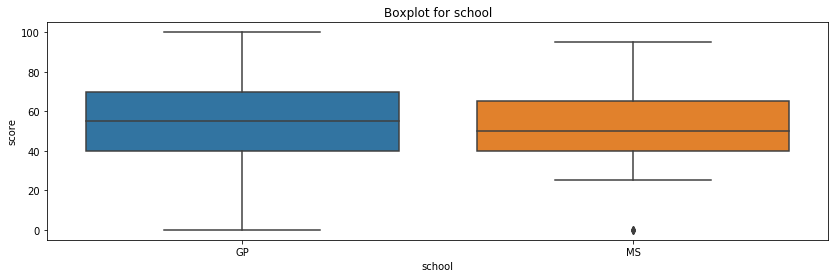

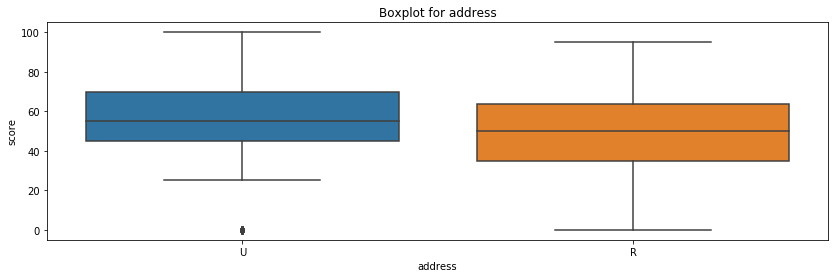

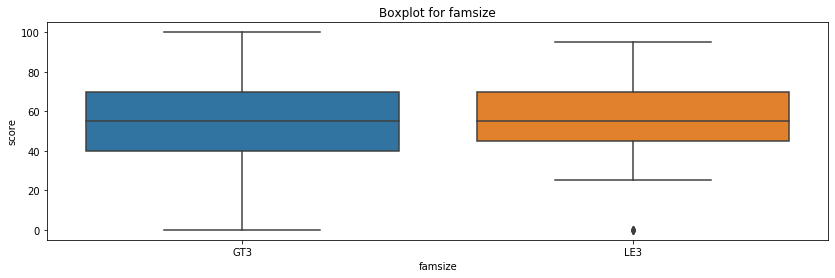

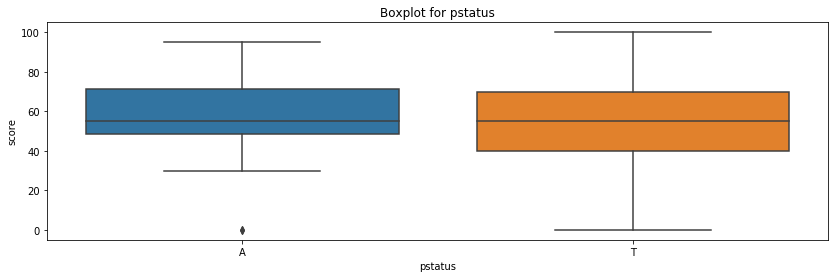

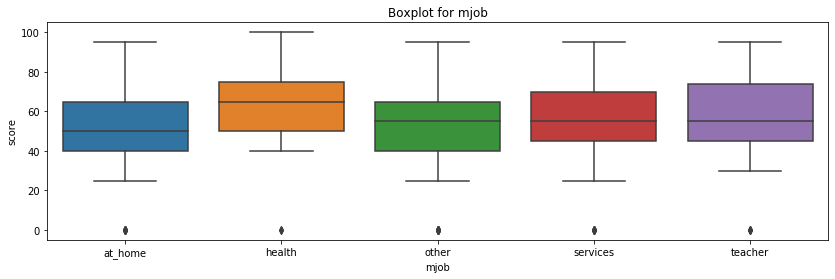

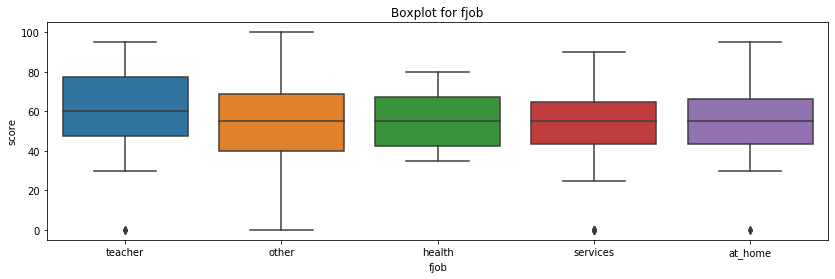

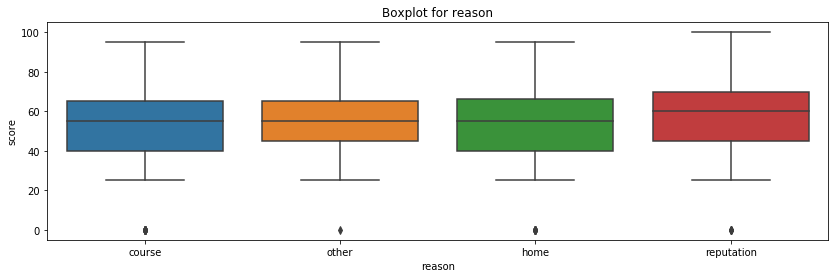

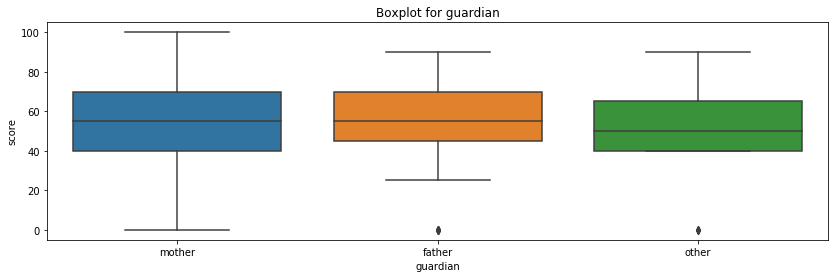

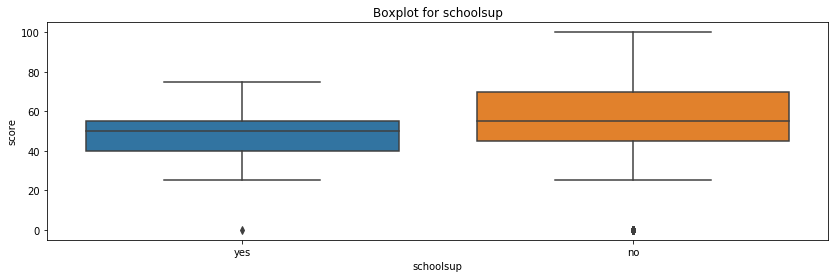

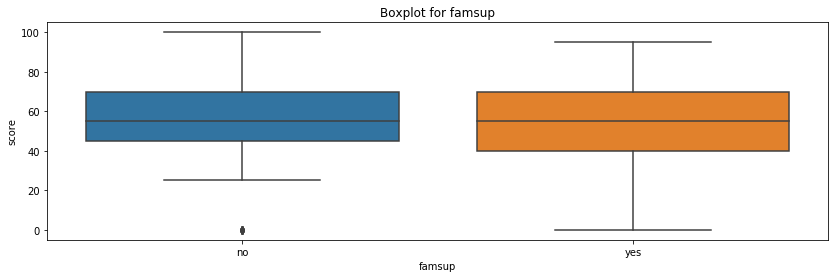

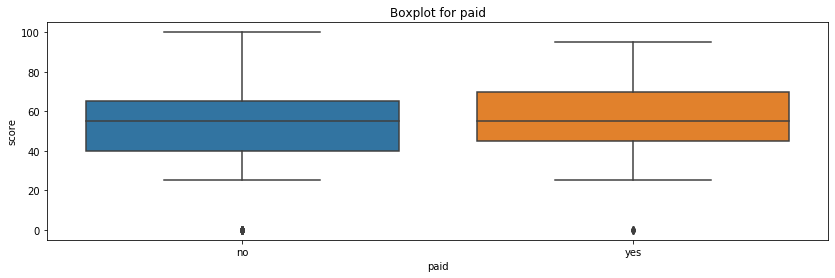

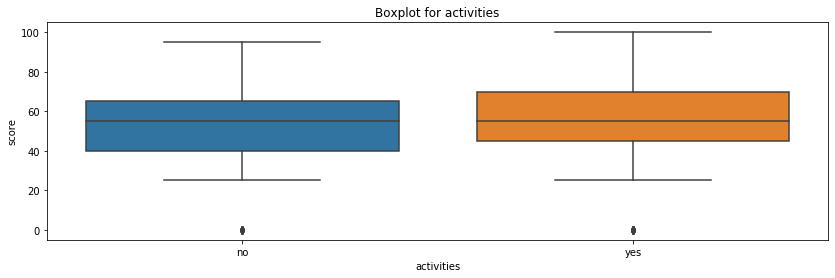

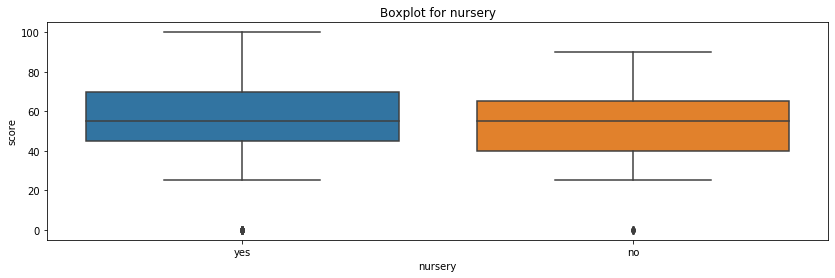

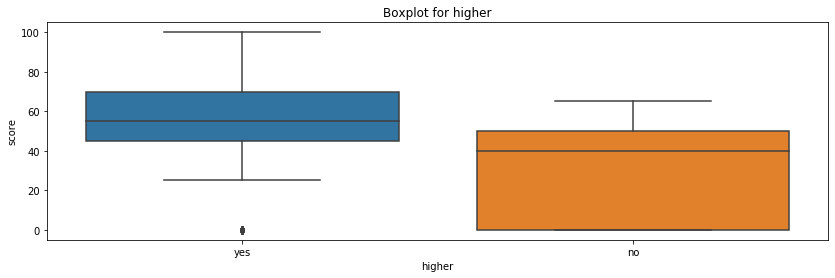

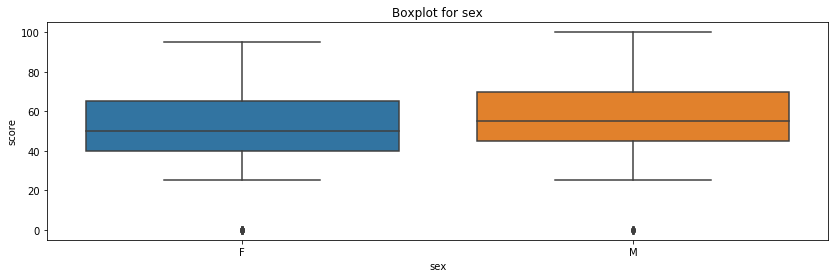

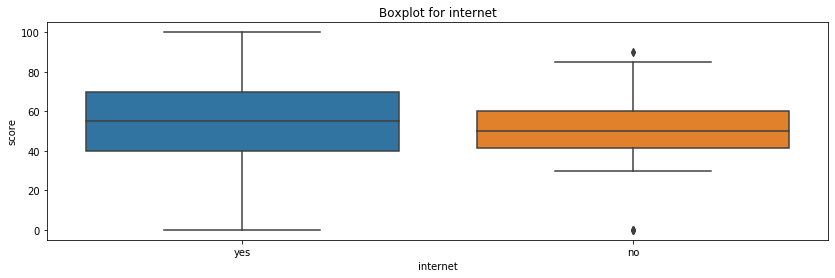

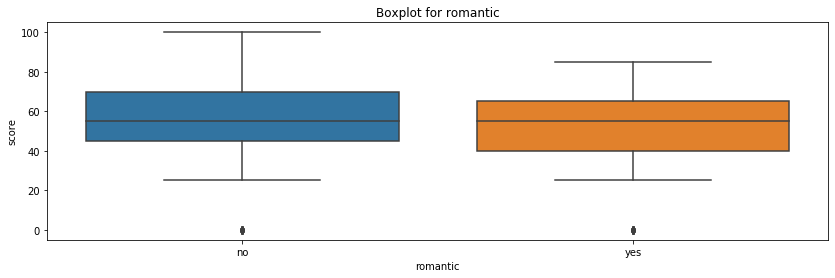

In [76]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_boxplot(col)

По условию задачи поиска группы риска, оцениваем факторы влияющие на ухудшение успеваемости.
Из графиков мы видим, что минимальных значений больше у учащихся:
<ul>
    <li>школы GP</li>
    <li>живущих за городом (address)</li>
    <li>с размеров семьи больше 3 человек (famsize)</li>
    <li>родители которых проживают совместно (pstatus)
    <li>опекуном которых является мать (guardian) - статистическое большинство
    <li>без дополнительной образовательной поддержки
    <li>имеющих учебную поддержку дома (famsup)
    <li>не занимающихся дополнительно (платно) (paid)
    <li>посещавших детский сад
    <li>не собирающихся получать высшее образование (higher) - сильно влияет
    <li>женского пола
    <li>имеющих доступ к интернету
    <li>состоящих в романтических отношениях
</ul>

Сделаем тест Стюдента

In [77]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:20]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [78]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки romantic


### Собираем датасет для модели
Немного выводов:
<ol>
    <li>В целом, сильно влияет образование родителей. Они коррелируют достаточно сильно, но я решил не объединять, чтобы выявить будущие зависимости от пола родителей. Образование отца сильнее влияет на успеваемость, но также выделяется позиция матери преподавателя.</li>
    <li>Также сильно влияют на успеваемость планы учащегося поступать в высшее учебное заведение. Если таких планов нет - то и мотивация соответствующая.</li>
    <li>Остальные параметры в меньшей степени влияют на результат, но их сумма может оказать решающее воздействие.</li>
</ol>

In [79]:
model = df[['school','age','sex','address', 'medu', 'fedu', 'mjob', 'fjob', 'studytime', 'failures','romantic','schoolsup','higher', 'goout', 'absences', 'score']]
model

,school,age,sex,address,medu,fedu,mjob,fjob,studytime,failures,romantic,schoolsup,higher,goout,absences,score
0,GP,18,F,U,4.0,4.0,at_home,teacher,2.0,0.0,no,yes,yes,4.0,6.0,30.0
1,GP,17,F,U,1.0,1.0,at_home,other,2.0,0.0,no,no,yes,3.0,4.0,30.0
2,GP,15,F,U,1.0,1.0,at_home,other,2.0,3.0,no,yes,yes,2.0,10.0,50.0
3,GP,15,F,U,4.0,2.0,health,other,3.0,0.0,yes,no,yes,2.0,2.0,75.0
4,GP,16,F,U,3.0,3.0,other,other,2.0,0.0,no,no,yes,2.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,MS,18,F,U,1.0,1.0,other,other,2.0,1.0,no,no,yes,1.0,0.0,0.0
368,MS,17,M,U,3.0,1.0,services,services,1.0,0.0,no,no,yes,5.0,3.0,80.0
369,MS,21,M,R,1.0,1.0,other,other,1.0,3.0,no,no,yes,3.0,3.0,35.0
370,MS,18,M,R,3.0,2.0,services,other,1.0,0.0,no,no,yes,1.0,0.0,50.0
